In [1]:
import warnings;warnings.filterwarnings('ignore')

import re
import os
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

from tqdm import tqdm
from datetime import datetime
from scipy.spatial import cKDTree
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from geopy.distance import geodesic
from geopy.distance import great_circle


# 1.데이터 로드

In [2]:
data_path = '../data'
train_path = f'{data_path}/new/new_train_ver5.csv'
test_path  = f'{data_path}/new/new_test_ver5.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
print('Train data shape : ', train_data.shape, 'Test data shape : ', test_data.shape)

# train/test 구분을 위한 칼럼 생성.
train_data['is_test'] = 0
test_data['is_test'] = 1
df = pd.concat([train_data, test_data]) # 하나의 데이터로 합친다.

Train data shape :  (1118822, 16) Test data shape :  (9272, 15)


# 2.GDP 추가

In [3]:
kor_gdp = pd.read_csv(f"{data_path}/new/kor-gdp.csv")
kor_gdp.head()

,통계표,계정항목,단위,변환,2001,2002,2003,2004,2005,2006,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,9.1.4.2. 국제 주요국 국내총생산(GDP),한국,백만달러,원자료,"547,743.1","626,989.2","702,696.2","792,532.0","934,707.9","1,052,610.2",...,"1,484,488.5","1,466,038.9","1,499,679.8","1,623,074.1","1,725,373.4","1,651,422.9","1,644,312.8","1,818,432.2","1,673,916.5","1,712,792.9"


In [4]:
gdp_data_cleaned = kor_gdp.melt(id_vars=["통계표", "계정항목", "단위", "변환"], 
                                var_name="Year", 
                                value_name="GDP")

gdp_data_cleaned = gdp_data_cleaned[gdp_data_cleaned["계정항목"] == "한국"]
gdp_data_cleaned = gdp_data_cleaned[["Year", "GDP"]]
gdp_data_cleaned["Year"] = gdp_data_cleaned["Year"].astype(int)
gdp_data_cleaned["GDP"] = gdp_data_cleaned["GDP"].str.replace(',', '').astype(float)

df['계약년월'] = pd.to_datetime(df['계약년월'])
df['Year'] = df['계약년월'].dt.year

df = pd.merge(df, gdp_data_cleaned, on='Year', how='left')
df = df.drop(columns=['Year'])

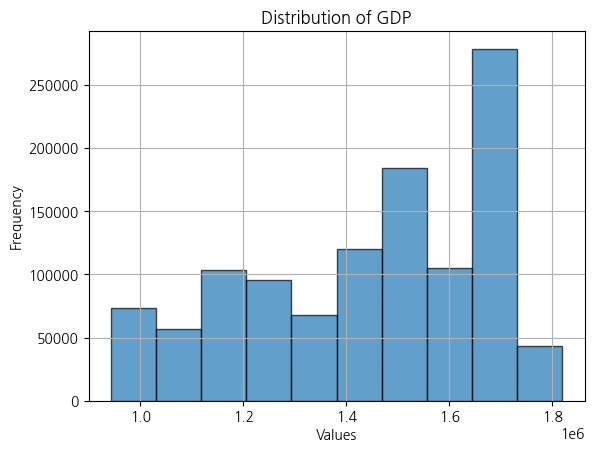

In [5]:
plt.hist(df['GDP'], edgecolor='k', alpha=0.7)
plt.title('Distribution of GDP')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 3. 기준금리 추가

In [6]:
kor_ir = pd.read_csv(f"{data_path}/new/kor-ir.csv")
kor_ir.head()

,Interest Rate Type,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,기준금리,5.0,3.0,2.0,2.5,3.25,2.75,2.5,2.0,1.5,1.25,1.5,1.75,1.25,0.5,1.0,3.25,3.5


In [7]:
df['계약연도'] = pd.to_datetime(df['계약년월']).dt.year
df['계약연도'] = df['계약연도'].astype(int)

interest_rate_data_transposed = kor_ir.set_index('Interest Rate Type').T
interest_rate_data_transposed.index = interest_rate_data_transposed.index.astype(int)

df['IR'] = df['계약연도'].map(interest_rate_data_transposed['기준금리'])
df = df.drop(columns=['계약연도'])

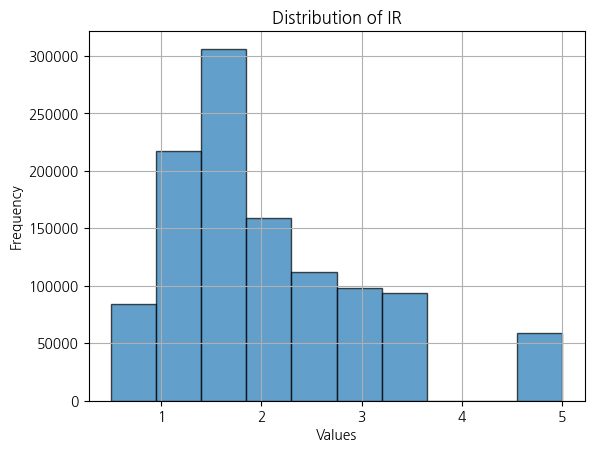

In [8]:
plt.hist(df['IR'], edgecolor='k', alpha=0.7)
plt.title('Distribution of IR')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 4.지하철, 버스 추가

In [9]:
subway_df = pd.read_csv(f"{data_path}/subway_feature.csv")
print(subway_df.shape)
subway_df.head()

(768, 5)


,역사_ID,역사명,호선,위도,경도
0,9996,미사,5호선,37.560927,127.193877
1,9995,강일,5호선,37.557490,127.175930
2,4929,김포공항,김포골드라인,37.562360,126.801868
3,4928,고촌,김포골드라인,37.601243,126.770345
4,4927,풍무,김포골드라인,37.612488,126.732387


In [10]:
bus_df = pd.read_csv(f"{data_path}/bus_feature.csv")
print(bus_df.shape)
bus_df.head()

(12584, 6)


,노드 ID,정류소번호,정류소명,X좌표,Y좌표,정류소 타입
0,100000001,1001,종로2가사거리,126.987752,37.569808,중앙차로
1,100000002,1002,창경궁.서울대학교병원,126.996566,37.579183,중앙차로
2,100000003,1003,명륜3가.성대입구,126.998251,37.582581,중앙차로
3,100000004,1004,종로2가.삼일교,126.987613,37.568579,중앙차로
4,100000005,1005,혜화동로터리.여운형활동터,127.001744,37.586243,중앙차로


In [11]:
print(df['좌표X'].min(), df['좌표X'].max())
print(df['좌표Y'].min(), df['좌표Y'].max())

126.7983185 127.1799976
37.4344200706203 37.6877248


In [12]:
# 고유한 X, Y 좌표 쌍 추출
unique_coordinates = df[['좌표X', '좌표Y']].drop_duplicates()

# KD-트리 생성
bus_tree = cKDTree(bus_df[['Y좌표', 'X좌표']].values)  # 위도, 경도 순서로 변경
subway_tree = cKDTree(subway_df[['위도', '경도']].values)

def count_nearby_stations_kdtree(row, bus_tree, subway_tree, bus_stops, subway_stations, threshold=0.5):
    # threshold는 km 단위로 그대로 사용
    threshold_in_km = threshold  # 0.5 km = 500 meters

    # 버스 정류장 근처 개수
    bus_indices = bus_tree.query_ball_point([row['좌표Y'], row['좌표X']], r=threshold_in_km)
    bus_count = sum(great_circle((row['좌표Y'], row['좌표X']), (bus_stops.iloc[i]['Y좌표'], bus_stops.iloc[i]['X좌표'])).km <= threshold for i in bus_indices)

    # 지하철역 근처 개수
    subway_indices = subway_tree.query_ball_point([row['좌표Y'], row['좌표X']], r=threshold_in_km)
    subway_count = sum(great_circle((row['좌표Y'], row['좌표X']), (subway_stations.iloc[i]['위도'], subway_stations.iloc[i]['경도'])).km <= threshold for i in subway_indices)

    return bus_count, subway_count

# 고유한 좌표 쌍에 대해 계산
unique_coordinates[['인근_버스정류장수', '인근_지하철역수']] = unique_coordinates.apply(
    count_nearby_stations_kdtree, axis=1, bus_tree=bus_tree, subway_tree=subway_tree, bus_stops=bus_df, subway_stations=subway_df, threshold=0.5, result_type="expand")

# 원래 데이터프레임에 결과를 반영
df = df.merge(unique_coordinates, on=['좌표X', '좌표Y'], how='left')

In [23]:
# 고유한 X, Y 좌표 쌍 추출
unique_coordinates = df[['좌표X', '좌표Y']].drop_duplicates()

# KD-트리 생성
bus_tree = cKDTree(bus_df[['X좌표', 'Y좌표']].values)
subway_tree = cKDTree(subway_df[['경도', '위도']].values)

def find_nearest_kdtree(point, tree, locations, lat_col, lon_col):
    distance, idx = tree.query(point, k=1)
    nearest_point = locations.iloc[idx]
    nearest_distance = great_circle((point[1], point[0]), (nearest_point[lat_col], nearest_point[lon_col])).meters
    return nearest_distance

# 고유한 좌표 쌍에 대해 최근접 버스정류장과 지하철역 거리 계산
unique_coordinates['최근접_버스정류장'] = unique_coordinates.apply(
    lambda row: find_nearest_kdtree([row['좌표X'], row['좌표Y']], bus_tree, bus_df, 'Y좌표', 'X좌표'), axis=1)

unique_coordinates['최근접_지하철역'] = unique_coordinates.apply(
    lambda row: find_nearest_kdtree([row['좌표X'], row['좌표Y']], subway_tree, subway_df, '위도', '경도'), axis=1)

# 원래 데이터프레임에 결과를 반영
df = df.merge(unique_coordinates, on=['좌표X', '좌표Y'], how='left')

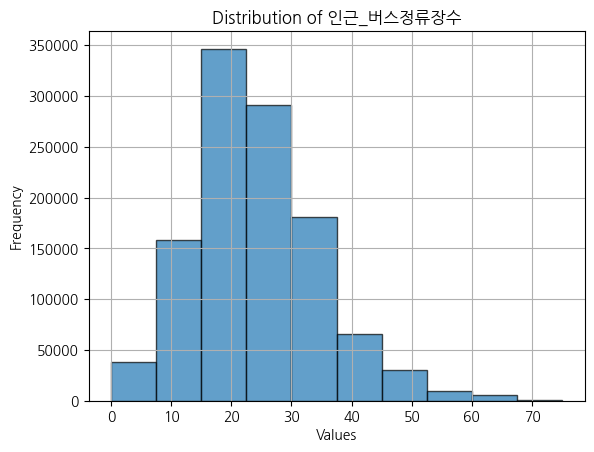

In [24]:
plt.hist(df['인근_버스정류장수'], edgecolor='k', alpha=0.7)
plt.title('Distribution of 인근_버스정류장수')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

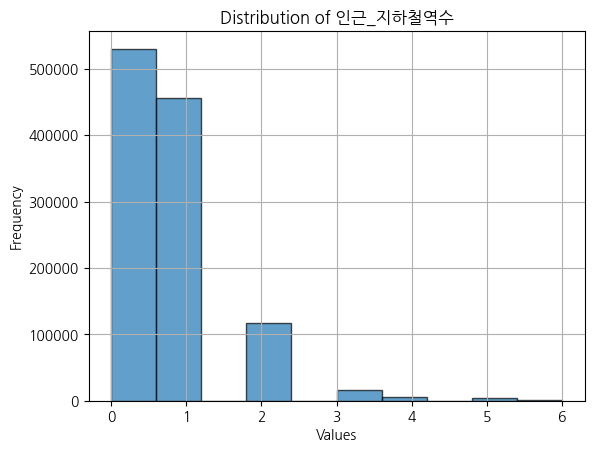

In [25]:
plt.hist(df['인근_지하철역수'], edgecolor='k', alpha=0.7)
plt.title('Distribution of 인근_지하철역수')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

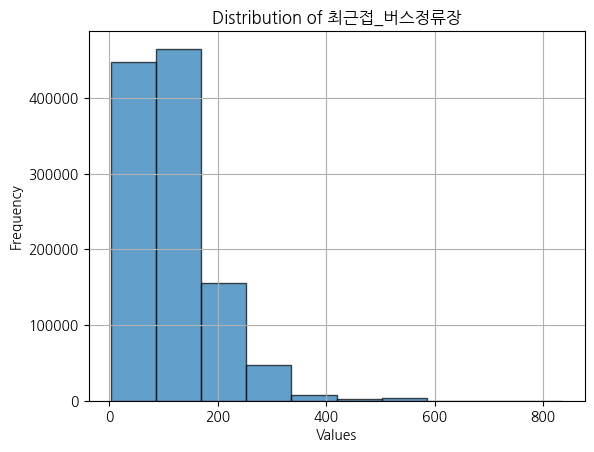

In [26]:
plt.hist(df['최근접_버스정류장'], edgecolor='k', alpha=0.7)
plt.title('Distribution of 최근접_버스정류장')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

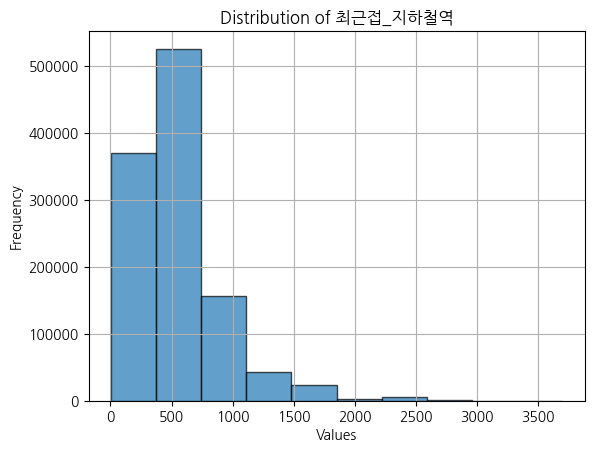

In [27]:
plt.hist(df['최근접_지하철역'], edgecolor='k', alpha=0.7)
plt.title('Distribution of 최근접_지하철역')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [30]:
df = df.drop(columns=['최근접_버스정류장_x', '최근접_지하철역_x', '최근접_버스정류장_y', '최근접_지하철역_y'])

In [31]:
train_df = df[df['is_test'] == 0]
test_df = df[df['is_test'] == 1]

train_df = train_df.drop(columns=['is_test'])
test_df = test_df.drop(columns=['is_test', 'target'])
print(train_df.shape, test_df.shape)

train_df.to_csv(f'{data_path}/new/new_train_ver6.csv', index=False)
test_df.to_csv(f'{data_path}/new/new_test_ver6.csv', index=False)

(1118822, 22) (9272, 21)


In [32]:
train_df.columns

Index(['시군구', '번지', '아파트명', '전용면적', '계약년월', '건축년도', '도로명', '해제사유발생일', '등기신청일자',
       'k-건설사(시공사)', '좌표X', '좌표Y', 'target', '세대별_주차대수', '건축년도-계약년도', '건설사랭크',
       'GDP', 'IR', '인근_버스정류장수', '인근_지하철역수', '최근접_버스정류장', '최근접_지하철역'],
      dtype='object')